In [ ]:
# Upgrade pip before start

try:
  import colab
  !pip install --upgrade pip
except:
  pass

     |████████████████████████████████| 1.6MB 4.2MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


# Getting the Kaggle.json and uploading it in order to download the NYC Taxi data

In [ ]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


# Querying the data and unarchiveing it

In [ ]:
!kaggle competitions download -c nyc-taxi-trip-duration

  0% 0.00/2.49M [00:00<?, ?B/s]
100% 2.49M/2.49M [00:00<00:00, 81.2MB/s]
 25% 5.00M/20.3M [00:00<00:00, 43.0MB/s]
100% 20.3M/20.3M [00:00<00:00, 99.5MB/s]
 99% 62.0M/62.9M [00:00<00:00, 51.3MB/s]
100% 62.9M/62.9M [00:00<00:00, 85.8MB/s]


In [ ]:
import zipfile
zf = '/content/train.zip'
zip_ref = zipfile.ZipFile(zf, 'r')
zip_ref.extractall('/content/train')
zip_ref.close()

In [ ]:
# Lets inspect the directory
!ls
!ls /content/train

kaggle.json  sample_data  sample_submission.zip  test.zip  train  train.zip
train.csv


# Various Imports


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from geopy.distance import geodesic
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
df = pd.read_csv('/content/train/train.csv')[:10000]

In [ ]:
# Inspecting data
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# Data Manipulation and Feature Engineering

In [ ]:
data_features = df.copy()

# Convert the pickup to date time
data_features['pickup_datetime'] = pd.to_datetime(data_features['pickup_datetime'])

# Convert and calculate trip duration
data_features['trip_duration'] = data_features['trip_duration'] / 60.

# Convert the datetime to month value
data_features['month'] = data_features['pickup_datetime'].dt.month

# Convert the datetime to hour
data_features['hour'] = data_features['pickup_datetime'].dt.hour

# Convert the datetime to day
data_features['day'] = data_features['pickup_datetime'].dt.day

# Convert the lat and lang to distanes
data_features['distance'] = data_features.apply(lambda x: geodesic((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).miles, axis=1)

# Drop NA 
data_features.dropna(inplace=True)

# Inspect the converted Dataset
data_features.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,hour,day,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,7.583333,3,17,14,0.933406
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,11.050000,6,0,12,1.123849
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,35.400000,1,11,19,3.964154
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,7.150000,4,19,6,0.921886
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,7.250000,3,13,26,0.737591


# Data Visualization

Text(0.5, 0, 'Passenger Count')

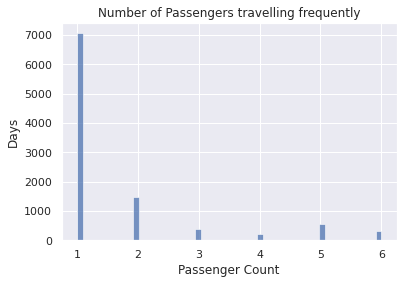

In [ ]:
sns.color_palette("Set2")
sns.set_theme(style="darkgrid")
ax = sns.histplot(data=data_features, x="passenger_count")
ax.set_title('Number of Passengers travelling frequently')
ax.set_ylabel('Days')
ax.set_xlabel('Passenger Count')

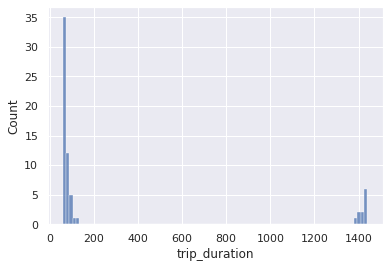

In [ ]:
# Trip duration greater than 60 mins
ls = sns.histplot(data=data_features[data_features['trip_duration'] > 60], x="trip_duration")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

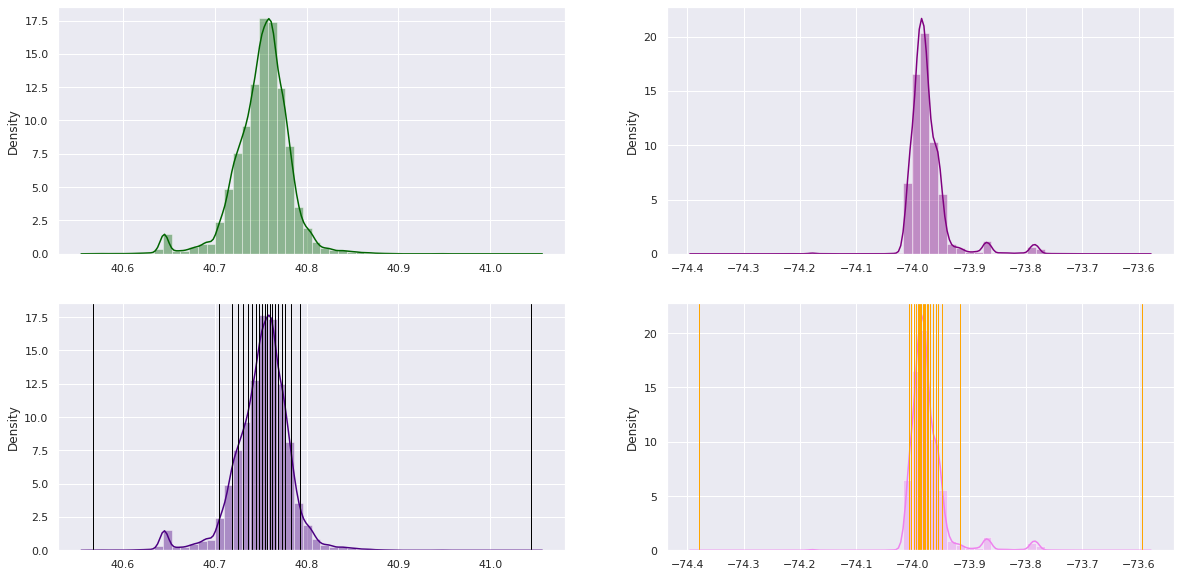

In [ ]:
import matplotlib.pyplot as plt
# Bucketing the latitude and longitude.

bins_lat = pd.qcut(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), q=20, duplicates='drop', retbins=True)[1]
bins_lon = pd.qcut(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), q=20, duplicates='drop', retbins=True)[1]

#Plot all latitude values with bins
f, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=False)
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[0, 0], color="darkgreen")
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[0, 1], color="purple")

#Plot bins
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[1, 0], color="indigo")
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[1, 1], color="violet")
for b_ in bins_lat:
  axes[1][0].axvline(b_, color='black', linewidth=1 )
for b_ in bins_lon:
  axes[1][1].axvline(b_, color='orange', linewidth=1 )

# Training in PyTorch

In [29]:
# Target Variable
label_col = 'trip_duration'

# The various predictors in the data set
X = data_features[['passenger_count', 'distance', 'month', 'day']].to_numpy()
y = data_features[[label_col]].to_numpy()

In [30]:
# Tensor inputs for the predictors
inputs = torch.tensor(X, dtype=torch.float32)

# Tensor input for the target
targets = torch.tensor(y, dtype=torch.float32)

# Creating a Dataset from the inputs and target using TensorDataset
dataset = TensorDataset(inputs, targets)

# Data Labels
data, label = dataset[0]
print(data, data.shape, label)

tensor([ 1.0000,  0.9334,  3.0000, 14.0000]) torch.Size([4]) tensor([7.5833])


In [31]:
# Validation Parameters
validation_part = 0.1
validation_size = int(validation_part * len(dataset))
train_size = len(dataset) - validation_size
train_ds, val_ds = random_split(dataset, [train_size, validation_size])
print(len(train_ds), len(val_ds))

9000 1000


In [ ]:
# Batch Size
batch_size = 32

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

# Implementing the PyTorch nn.Module for the Linear Model

In [46]:
# Implementing NN model using nn.Module
class NeuralNet(nn.Module):
  def __init__(self, input, H_val, output, continuous, categorical):
    super(NeuralNet, self).__init__()
    self.linear_deep1 = nn.Linear(continuous, H_val) 
    self.linear_deep2 = nn.Linear(H_val, H_val)
    self.linear_final3 = nn.Linear(continuous + categorical, 1)
    self.continuous = continuous
    self.categorical = categorical

  def __call__(self, x):
    continuous_features = x[:,range(self.continuous)]
    categorical_features = x[:,range(self.continuous, self.continuous + self.categorical)]

    relu1 = F.relu(self.linear_deep1(continuous_features))
    relu2 = F.relu(self.linear_deep2(relu1))

    x = torch.cat((relu2, categorical_features), dim=1)
    y_pred = self.linear_final3(x)
    return y_pred

In [47]:
input, H_val, output = data.shape[0], 2, 1
print(inp, H_val, out)

model = NeuralNet(input, H_val, output, 2, 2)

4 2 1


In [48]:
# options
epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lmbda = lambda epoch: 0.95
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

for epoch in range(epochs):
  running_loss = 0.0
  for batch_id, (X_train, y_train) in enumerate(train_loader, 0):
    optimizer.zero_grad()

    y_pred = model(X_train)

    # Compute and print loss
    loss = criterion(y_pred, y_train)
    print(loss)
    loss.backward()
    optimizer.step()
    scheduler.step()


tensor(211.7692, grad_fn=<MseLossBackward>)
tensor(340.0032, grad_fn=<MseLossBackward>)
tensor(227.4085, grad_fn=<MseLossBackward>)
tensor(202.8698, grad_fn=<MseLossBackward>)
tensor(219.5933, grad_fn=<MseLossBackward>)
tensor(60077.3984, grad_fn=<MseLossBackward>)
tensor(227.6048, grad_fn=<MseLossBackward>)
tensor(177.8917, grad_fn=<MseLossBackward>)
tensor(264.4910, grad_fn=<MseLossBackward>)
tensor(124.7707, grad_fn=<MseLossBackward>)
tensor(162.9723, grad_fn=<MseLossBackward>)
tensor(202.8606, grad_fn=<MseLossBackward>)
tensor(289.5774, grad_fn=<MseLossBackward>)
tensor(135.4664, grad_fn=<MseLossBackward>)
tensor(219.1307, grad_fn=<MseLossBackward>)
tensor(229.2130, grad_fn=<MseLossBackward>)
tensor(307.8755, grad_fn=<MseLossBackward>)
tensor(64285.1250, grad_fn=<MseLossBackward>)
tensor(461.0824, grad_fn=<MseLossBackward>)
tensor(225.7554, grad_fn=<MseLossBackward>)
tensor(260.3524, grad_fn=<MseLossBackward>)
tensor(115.8300, grad_fn=<MseLossBackward>)
tensor(340.1523, grad_fn=<Ms